In [2]:
#Important imports
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch import optim 
import matplotlib.pyplot as plt
from torch.nn import functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms,models
import matplotlib.pyplot as plt

#Choosing devide to be gpu if have one, else cpu
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')   

In [3]:
transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

In [4]:
train_data = ImageFolder(r'D:\Eu\cvcamp\training_set', transform = transformations)
test_data = ImageFolder(r'D:\Eu\cvcamp\test_set', transform = transformations)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


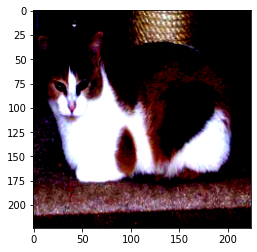

In [5]:
plt.imshow((train_data[100][0]).permute(1, 2, 0) )

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        # (224, 224)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        
        self.pool1 = nn.MaxPool2d(2)
        
        # (112, 112)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        
        self.pool2 = nn.MaxPool2d(2)
        
        # (56, 56)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        
        self.pool3 = nn.MaxPool2d(2)
        
        # (28, 28)
        
        self.flatten = nn.Flatten()
        
        # fully-connected layers
        self.fc1 = nn.Linear(128*28*28, 256) # 128 = nr of filters
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)
        
        
    def forward(self, x):
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = self.pool3(F.relu(self.conv3(out)))

        out = self.flatten(out)
        
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = torch.sigmoid(self.fc3(out))

        return out       

In [7]:
def training_loop(n_epoch, optimizer, model, loss_fn, train_loader, test_loader, print_plot):
    
    train_accuracy = torch.zeros(n_epoch)
    test_accuracy = torch.zeros(n_epoch)
    
    for epoch in range(n_epoch):
        
        for example, label in train_loader:
            
            example = example.to(DEVICE)
            label = label.to(DEVICE)
            
            label = label.unsqueeze(1)
            
            output = model(example.float())
            
            # eraoarea care se calculeaza
            loss = loss_fn(output, label.float())
            
            optimizer.zero_grad() #zero gradient. erorile care s-au acumulat trebuie sterse
            loss.backward()
            optimizer.step()
        
        with torch.no_grad():

            for loader, accuracy in [(train_loader, train_accuracy),(test_loader, test_accuracy)]:
                correct = 0
                total = 0

                for examples, labels in loader:
                    examples = examples.to(device=DEVICE)
                    labels = labels.to(device=DEVICE).view(-1, 1)

                    outputs = model(examples.float())
                    predicted = torch.round(outputs)

                    total += labels.shape[0]
                    correct += (predicted == labels).sum()

                accuracy[epoch] = correct / total

        
        print(f'Epoch {epoch+1})', 
                f'Train Accuracy: {train_accuracy[epoch]}',
                f'Test Accuracy: {test_accuracy[epoch]}')
    
    if print_plot:
    #Setting x-ticks
        epochs = range(n_epoch)

        #Ploting both curves, train and val 
        plt.plot(epochs, train_accuracy, 'g', label='Training accuracy')
        plt.plot(epochs, test_accuracy, 'b', label='Test accuracy')
        plt.title('Training and Test loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show() 

In [8]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = True)

In [9]:
learning_rate = 1e-3 # 0.001

model = Net().to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
from collections import OrderedDict

model = models.resnet50(pretrained = True)

for param in model.parameters():
    param.required_grad = False

nr_feat = model.fc.in_features #2048
model.fc = nn.Sequential(OrderedDict([('fc', nn.Linear(nr_feat, 1)), ('sigmoid', nn.Sigmoid())]))

learning_rate = 1e-3 # 0.001

model = model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr = learning_rate)
loss_fn = nn.BCELoss()

training_loop(
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    print_plot = True,
    train_loader = train_loader,
    test_loader = test_loader
)
                         


In [37]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [53]:
print(torch.cuda.is_available())

False
